<a href="https://colab.research.google.com/github/trigo613/RockDodger_DQN/blob/main/RockDodger_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
from numpy.random import rand,randint
import numpy as np

In [60]:
class Dodger():
    SCREEN_SIZE = (32,32)
    PLAYER_SIZE = (2,2)

    ROCK_MIN_HEIGHT = 2
    ROCK_MAX_HEIGHT = 5

    ROCK_MIN_WIDTH = 2
    ROCK_MAX_WIDTH = 5

    ROCK_SPEED = 2

    PLAYER_Y = SCREEN_SIZE[0] - PLAYER_SIZE[0]*2 #Top (not middle)
    PLAYER_INIT_X = int(SCREEN_SIZE[1]/2)

    PLAYER_PIXEL = 2
    ROCK_PIXEL = 1

    ROCK_REWARD = 2

    ROCK_PIXEL_NOISE = 0.5
    EMPTY_PIXEL = 0

    TIMER_MIN = 1
    TIMER_MAX = 4

    ACTION_SPACE = ['L','R','N']

    def __init__(self):
        self.grid = None
        self.player_x = self.PLAYER_INIT_X
        self.time_until_next_rock = self.TIMER_MIN
        self.reward = 0
        self.done = 0
        self.rocks_list = [] #each element in list is of type {'x' : _, 'y' : _ , 'width' : _ , 'height' : _}

    def __generate_grid_with_player(self):
        self.grid = np.zeros(self.SCREEN_SIZE)
        self.grid[self.PLAYER_Y:self.PLAYER_Y+self.PLAYER_SIZE[0],self.player_x:self.player_x+self.PLAYER_SIZE[1]] = self.PLAYER_PIXEL

    def __restart_rock_counter(self):
        self.time_until_next_rock = np.random.randint(self.TIMER_MIN,self.TIMER_MAX)

    def __generate_rock(self):
        self.time_until_next_rock -= 1
        if self.time_until_next_rock > 0:
            return
        #Generating rock if time reached zero
        rock_height =  np.random.randint(self.ROCK_MIN_HEIGHT,self.ROCK_MAX_HEIGHT)
        rock_width = np.random.randint(self.ROCK_MIN_WIDTH,self.ROCK_MAX_WIDTH)
        rock_y = - rock_height
        if random.random() < 0.7:
            rock_x = np.random.randint(0,self.SCREEN_SIZE[1] - rock_width + 1)
        else:
            rock_x = self.player_x
            if rock_x + rock_width > self.SCREEN_SIZE[1]:
                rock_x = self.SCREEN_SIZE[1] - rock_width
        rock_color = self.ROCK_PIXEL + random.uniform(-self.ROCK_PIXEL_NOISE, self.ROCK_PIXEL_NOISE)
        self.rocks_list.append({'x' : rock_x,
                               'y' :rock_y ,
                               'width' : rock_width ,
                               'height' :rock_height,
                               'color' : rock_color})
        self.__restart_rock_counter()


    def __render_rocks(self):
        new_rocks_list = []
        for rock in self.rocks_list:
            rock['y'] += self.ROCK_SPEED
            if rock['y'] < self.SCREEN_SIZE[0]:
                y_start = max(0, rock['y'])
                y_end = min(self.SCREEN_SIZE[0], rock['y'] + rock['height'])
                self.grid[y_start:y_end, rock['x']:rock['x'] + rock['width']] = rock['color']
                new_rocks_list.append(rock)
            else:
                self.reward += self.ROCK_REWARD
        self.rocks_list = new_rocks_list


    def __check_collisions(self):
        collision_detected = False
        for rock in self.rocks_list:
            if (self.player_x < rock['x'] + rock['width'] and self.player_x + self.PLAYER_SIZE[1] > rock['x'] and
                self.PLAYER_Y < rock['y'] + rock['height'] + 1 and self.PLAYER_Y + self.PLAYER_SIZE[0] > rock['y']):
                self.reward -= 15
                self.done = 1
                break

    def __move_player(self, action):
        assert action in self.ACTION_SPACE
        if action == 'L' and self.player_x > 0:
                self.player_x -= 1
        elif action == 'R' and self.player_x + self.PLAYER_SIZE[1] < self.SCREEN_SIZE[1]:
                self.player_x += 1

    def info(self):
        return {"scree_size" : self.SCREEN_SIZE,
                "action_space":self.ACTION_SPACE,
                "goal": "The goal of the game is for the" +
                        "player to dodge all the rocks falling at him " +
                        "by moving left (L) or right (R) or staying still (N)." +
                        "every rock dodged earns him a point," +
                        "if the player collides with a rock then he loses"}

    def reset(self):
        self.reward = 0
        self.done = 0
        self.player_x = self.PLAYER_INIT_X
        self.__generate_grid_with_player()
        self.__restart_rock_counter()
        self.reward_earned = False
        self.rocks_list = []
        return {'state' : self.grid,
                'reward':0,
                'done' : 0}

    def step(self,action):
        self.reward = 0
        self.done = 0
        self.__move_player(action)
        self.__generate_grid_with_player()
        self.__generate_rock() #Checks if needs to generate a rock
        self.__render_rocks() #Renders the rocks and updates the reward
        self.__check_collisions()
        return {'state' : self.grid,
                'reward':self.reward,
                'done' : self.done}

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [62]:
class CNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(CNN, self).__init__()

        # Define the convolutional layers in a Sequential block
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()

        linear_input_size = self.calculate_conv_output_size(h, w)
        self.head = nn.Linear(linear_input_size, outputs)

    def calculate_conv_output_size(self, h, w):
        with torch.no_grad():
            x = torch.zeros(1, 1, h, w)
            x = self.conv_layers(x)
            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return self.head(x)

In [63]:
class DQNAgent:
    def __init__(self, state_shape, n_actions, device):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.device = device

        self.policy_net = CNN(state_shape[0], state_shape[1], n_actions).to(device)
        self.target_net = CNN(state_shape[0], state_shape[1], n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.target_net.eval() #Turn off training for target model

        self.optimizer = optim.Adam(self.policy_net.parameters())

        self.memory = deque(maxlen=10000)

        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.target_update = 10

        self.steps_done = 0
        self.episodes_played = 0

    def select_action(self, state, best = False):
        if not best and random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return torch.argmax(q_values, dim=1).item()
        else:
            return random.randrange(self.n_actions)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = np.array(state_batch)  # Convert the list of numpy arrays into a single numpy array
        state_batch = torch.FloatTensor(state_batch).unsqueeze(1).to(self.device)

        action_batch = torch.LongTensor(action_batch).to(self.device)

        reward_batch = torch.FloatTensor(reward_batch).to(self.device)

        next_state_batch = np.array(next_state_batch)
        next_state_batch = torch.FloatTensor(next_state_batch).unsqueeze(1).to(self.device)

        done_batch = torch.FloatTensor(done_batch).to(self.device)

        q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

        next_q_values = torch.max(self.target_net(next_state_batch), dim=1)[0].detach()
        expected_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [64]:
def play_dqn_agent_best(env, agent, max_steps=2000):
  state = env.reset()['state']
  frames = [state]
  for step in range(max_steps):
      action = agent.select_action(state,best=True)
      action_map = {0: 'L', 1: 'R', 2: 'N'}
      next_state_dict = env.step(action_map[action])
      next_state,done = next_state_dict['state'],next_state_dict['done']
      frames.append(next_state)
      state = next_state
      if done:
          break
  return frames


In [65]:
import imageio
import cv2
from skimage.transform import resize
def test_and_record_dqn_agent(env, agent,output_path, n_episodes=1, max_steps=2000,):
    frames = play_dqn_agent_best(env, agent, max_steps)
    def upscale_image(image, scale_factor):
        return cv2.resize(image, None, fx=scale_factor, fy=scale_factor,
                      interpolation=cv2.INTER_NEAREST)
    frames = [upscale_image(f,6) for f in frames]
    with imageio.get_writer(output_path, mode='I', fps=20) as writer:
      for frame in frames:
        writer.append_data((frame * 255).astype('uint8'))


In [66]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
def test_and_display_dqn_agent(env, agent, n_episodes=1, max_steps=2000):
    def display_frames(frames, delay=0.1):
      for frame in frames:
        plt.imshow(frame, vmin=0, vmax=2)
        plt.axis('off')  # Turn off axis labels
        display(plt.gcf())  # Display the current frame
        time.sleep(delay)  # Delay between frames
        clear_output(wait=True)  # Clear the previous frameb
    frames = play_dqn_agent_best(env, agent, max_steps)
    display_frames(frames)

In [67]:
# Training loop
def train_dqn_agent(env, agent, n_episodes=10_000, max_steps=10_000, record = False ,record_every = 200):
    for episode in range(n_episodes):
        state = env.reset()['state']
        total_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            action_map = {0: 'L', 1: 'R', 2: 'N'}
            next_state_dict = env.step(action_map[action])
            next_state, reward, done = next_state_dict['state'], next_state_dict['reward'], next_state_dict['done']

            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward

            if done:
                break

        if episode % agent.target_update == 0:
            agent.update_target_network()

        agent.episodes_played += 1
        if record == True and agent.episodes_played % record_every == 0:
          output_path = "output" + str(agent.episodes_played) + ".gif"
          print("recording agent and saving at ", output_path)
          test_and_record_dqn_agent(env, agent,output_path)
        print(f"Episode: {agent.episodes_played}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

In [68]:
env = Dodger()
state_shape = env.SCREEN_SIZE
n_actions = 3  # Left, Right, No-op
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
agent = DQNAgent(state_shape, n_actions, device)

In [70]:
device

device(type='cuda')

In [71]:
train_dqn_agent(env, agent,record = True)

Episode: 1, Total Reward: -9, Epsilon: 1.00
Episode: 2, Total Reward: -11, Epsilon: 1.00
Episode: 3, Total Reward: -15, Epsilon: 1.00
Episode: 4, Total Reward: -15, Epsilon: 0.94
Episode: 5, Total Reward: -15, Epsilon: 0.86
Episode: 6, Total Reward: -15, Epsilon: 0.79
Episode: 7, Total Reward: -15, Epsilon: 0.72
Episode: 8, Total Reward: -9, Epsilon: 0.64
Episode: 9, Total Reward: -1, Epsilon: 0.55
Episode: 10, Total Reward: -15, Epsilon: 0.51
Episode: 11, Total Reward: -15, Epsilon: 0.48
Episode: 12, Total Reward: -15, Epsilon: 0.44
Episode: 13, Total Reward: 3, Epsilon: 0.38
Episode: 14, Total Reward: -15, Epsilon: 0.35
Episode: 15, Total Reward: -13, Epsilon: 0.32
Episode: 16, Total Reward: 3, Epsilon: 0.27
Episode: 17, Total Reward: -15, Epsilon: 0.25
Episode: 18, Total Reward: -7, Epsilon: 0.22
Episode: 19, Total Reward: -15, Epsilon: 0.20
Episode: 20, Total Reward: -15, Epsilon: 0.19
Episode: 21, Total Reward: -5, Epsilon: 0.16
Episode: 22, Total Reward: 1, Epsilon: 0.14
Episode:

KeyboardInterrupt: 

In [58]:
env = Dodger()
test_and_record_dqn_agent(env, agent,output_path='resized_output_RSMprop.gif')

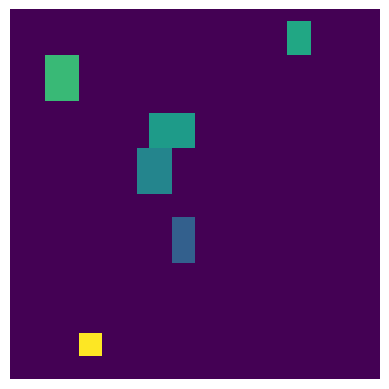

KeyboardInterrupt: 

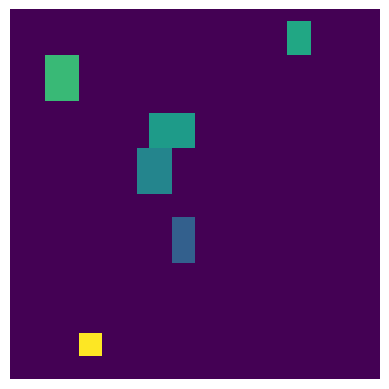

In [35]:
env = Dodger()
test_and_display_dqn_agent(env, agent)